# Проект 2.2 | Обучение с учителем: качество модели

**Краткое описание проекта**

Интернет-магазин «В один клик» сталкивается со спадом активности постоянных покупателей. Чтобы удержать клиентов, нам предстоит создать систему персонализированных предложений на основе данных и бизнес-моделирования.

**Что нам нужно сделать**

1. **Промаркировать активность**
   Определяем два статуса финансовой активности клиента: «снизилась» и «прежний уровень».

2. **Собрать данные по четырём группам признаков**

   * **Коммуникация** с клиентом.
   * **Продуктовое поведение**: какие товары и как часто покупает.
   * **Финансовое поведение**: сколько тратит в магазине.
   * **Поведение на сайте**: число просмотренных страниц, время на сайте.

3. **Построить модель**
   Прогнозируем вероятность снижения покупательской активности в ближайшие три месяца.

4. **Учесть прибыльность**
   Добавляем информацию о доходе, который каждый клиент принёс за последние три месяца.

5. **Сегментировать клиентов и сформировать предложения**
   Используем прогноз и данные о доходности, чтобы выделить сегменты и разработать персонализированные акции для каждого из них.


## Оглавление проекта<a id="0"></a>

1. [Оглавление](#0)
2. [Библиотеки и функции](#1)
3. [Загрузка данных](#2)
4. [Предобработка данных](#3)
    * [Нормализация названий столбцов](#4)
    * [Проверка типов данных](#5)
    * [Предобработка пропусков](#6)
    * [Работа с дубликатами](#7)
5. [Исследовательский анализ данных](#8)
    * [market_customer_df](#9)
    * [market_money_df](#10)
    * [market_time_df](#11)
    * [money_df](#12)
    * [Сравнительный анализ](#13)
6. [Объединение таблиц](#15)
7. [Корреляционный анализ](#16)
8. [Использование пайплайнов и итоговая модель](#17)
9. [Анализ важностей признаков](#18)
10. [Сегментация покупателей](#19)
11. [Итоговый вывод](#20)
12. [Рекомендации бизнесу](#21)

## Библиотеки и функции<a id="1"></a> 

In [1]:
!pip install shap

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shap
import math
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.1
    Uninstalling joblib-1.1.1:
      Successfully uninstalled joblib-1.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires joblib~=1.1.0, but you have joblib 1.5.2 which is incompatible.


In [2]:
#Я ПОНЯТИЯ НЕ ИМЕЮ ЧТО ОНО ДЕЛАЕТ. ОНО ЧИНИТ ШЕПЛИ, НО ЗАПУСКАТЬ НА СВОЙ СТРАХ И РИСК

!pip install --upgrade ipywidgets
!jupyter nbextension enable --py widgetsnbextension --sys-prefix
!pip install ipywidgets widgetsnbextension
!jupyter nbextension enable --py widgetsnbextension --sys-prefix
!pip install ipywidgets
!jupyter labextension install @jupyter-widgets/jupyterlab-manager@^2.0.0
!jupyter lab build

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: console dejavu events execute kernel kernelspec lab
labextension labhub migrate nbconvert notebook qtconsole run server
troubleshoot trust

Jupyter command `jupyter-nbextension` not found.
usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
         

In [3]:
# Нормализатор названий колонок. Оставлю кирилицу с маленькой буквы и с пробелом

def normalize_columns(df: pd.DataFrame):
    df.columns = [col.lower().replace('_', ' ') for col in df.columns]

In [4]:
# Просмотр не числовых уникальных значений датасета

def unique_non_numeric(df):
    for col in df.select_dtypes(exclude='number').columns:
        print(col, df[col].unique())
    

In [5]:
#Быстрая отрисовка гистограммы и боксплота для количественных признаков

def plot_column(column: pd.Series, bins: int = 30, figsize: tuple = (12, 5)) -> None:
    data = column.dropna()
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Гистограмма
    axes[0].hist(data, bins=bins, edgecolor='black')
    axes[0].set_title('Гистограмма')
    axes[0].set_xlabel(column.name)
    axes[0].set_ylabel('Количество клиентов')
    
    # Боксплот
    axes[1].boxplot(data, vert=False)
    axes[1].set_title('Боксплот')
    axes[1].set_xlabel(column.name)
    
    plt.tight_layout()
    plt.show()

In [6]:
#Просмотр пай чартов кат признаков

def plot_categorical_pie_charts(df: pd.DataFrame, figsize=(4, 4)) -> None:
    # Выбираем категориальные столбцы
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    n = len(cat_cols)
    if n == 0:
        print("Категориальных признаков не найдено.")
        return

    fig, axes = plt.subplots(1, n, figsize=(figsize[0] * n, figsize[1]))
    if n == 1:
        axes = [axes]

    for ax, col in zip(axes, cat_cols):
        counts = df[col].value_counts()
        ax.pie(counts, labels=counts.index, autopct='%1.1f%%')
        ax.set_title(col)

    plt.tight_layout()
    plt.show()


In [7]:
# Функция для сравнения при анализе

def plot_hist(df, column, hue):
    plt.figure(figsize=(8,6))
    plot = sns.histplot(df, bins=20, kde=True, hue=hue, x=column)
    plot.set_title(f'Рапределение для {column}', fontsize=16)
    plot.set_ylabel('Кол-во наблюдений', fontsize=14)

In [8]:
# Функция для сравнения при анализе

def plot_hist(df, column, hue):
    plt.figure(figsize=(8,6))
    plot = sns.histplot(df, bins=20, kde=True, hue=hue, x=column)
    plot.set_title(f'Рапределение для {column}', fontsize=16)
    plot.set_ylabel('Кол-во наблюдений', fontsize=14)

## Загрузка данных<a id="2"></a>

Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

In [9]:
market_customer_df = pd.read_csv('market_file.csv')
market_customer_df.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


**Значения в таблице**

* id — номер покупателя в корпоративной базе данных.
* Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
* Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
* Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
* Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это * значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
* Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
* Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
* Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
* Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
* Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
* Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
* Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
* Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

In [10]:
market_money_df = pd.read_csv('market_money.csv')
market_money_df.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


**Данные в таблице**

* id — номер покупателя в корпоративной базе данных.
* Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
* Выручка — сумма выручки за период.

Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

In [11]:
market_time_df = pd.read_csv('market_time.csv')
market_time_df.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


**Данные в таблице**

* id — номер покупателя в корпоративной базе данных.
* Период — название периода, во время которого зафиксировано общее время.
* минут — значение времени, проведённого на сайте, в минутах.

Таблица с данными о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

In [12]:
money_df = pd.read_csv('money.csv', sep = ';')
money_df.head()

,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


**Данные в таблице**

* Таблица с данными о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
* id — номер покупателя в корпоративной базе данных.
* Прибыль — значение прибыли.

**Данные в таблицах соответствуют описанию. Исследованием и объединением данных мы займемся позже.**

## Предобработка данных<a id="3"></a>

### Нормализация названий столбцов<a id="4"></a>

Проведу предобработку данных:

Сначала нормализую названия колонок датафреймов. Сделаю snace_case, но оставлю пробелы

In [13]:
dfs = [market_customer_df, market_money_df, market_time_df, money_df]

In [14]:
for entry in dfs:
    display(entry.columns)
    print('\n')

Index(['id', 'Покупательская активность', 'Тип сервиса', 'Разрешить сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит'],
      dtype='object')

Index(['id', 'Период', 'Выручка'], dtype='object')

Index(['id', 'Период', 'минут'], dtype='object')

Index(['id', 'Прибыль'], dtype='object')

In [15]:
for entry in dfs:
    normalize_columns(entry)
    print(entry.columns)

Index(['id', 'покупательская активность', 'тип сервиса', 'разрешить сообщать',
       'маркет актив 6 мес', 'маркет актив тек мес', 'длительность',
       'акционные покупки', 'популярная категория',
       'средний просмотр категорий за визит',
       'неоплаченные продукты штук квартал', 'ошибка сервиса',
       'страниц за визит'],
      dtype='object')
Index(['id', 'период', 'выручка'], dtype='object')
Index(['id', 'период', 'минут'], dtype='object')
Index(['id', 'прибыль'], dtype='object')


### Проверка типов данных<a id="5"></a>

Таперче проверим данные

In [16]:
for entry in dfs:
    display(entry.head(2))
    display(entry.info())
    print('\n')

,id,покупательская активность,тип сервиса,разрешить сообщать,маркет актив 6 мес,маркет актив тек мес,длительность,акционные покупки,популярная категория,средний просмотр категорий за визит,неоплаченные продукты штук квартал,ошибка сервиса,страниц за визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская активность            1300 non-null   object 
 2   тип сервиса                          1300 non-null   object 
 3   разрешить сообщать                   1300 non-null   object 
 4   маркет актив 6 мес                   1300 non-null   float64
 5   маркет актив тек мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные покупки                    1300 non-null   float64
 8   популярная категория                 1300 non-null   object 
 9   средний просмотр категорий за визит  1300 non-null   int64  
 10  неоплаченные продукты штук квартал   1300 non-null   int64  
 11  ошибка сервиса                

None

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None

,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None

,id,прибыль
0,215348,"0,98"
1,215349,"4,16"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


None

В последнем датасете прибыль должна быть float, а у нас - object

Перейду к обработке пропусков:

### Предобработка пропусков<a id="6"></a>

In [17]:
for entry in dfs:
    display(entry.isna().sum())
    print('\n')

id                                     0
покупательская активность              0
тип сервиса                            0
разрешить сообщать                     0
маркет актив 6 мес                     0
маркет актив тек мес                   0
длительность                           0
акционные покупки                      0
популярная категория                   0
средний просмотр категорий за визит    0
неоплаченные продукты штук квартал     0
ошибка сервиса                         0
страниц за визит                       0
dtype: int64

id         0
период     0
выручка    0
dtype: int64

id        0
период    0
минут     0
dtype: int64

id         0
прибыль    0
dtype: int64

Пропусков нет. Обработаем дубликаты:

### Работа с дубликатами<a id="7"></a>

In [18]:
for entry in dfs:
    display(entry.isna().sum())
    print('\n')

id                                     0
покупательская активность              0
тип сервиса                            0
разрешить сообщать                     0
маркет актив 6 мес                     0
маркет актив тек мес                   0
длительность                           0
акционные покупки                      0
популярная категория                   0
средний просмотр категорий за визит    0
неоплаченные продукты штук квартал     0
ошибка сервиса                         0
страниц за визит                       0
dtype: int64

id         0
период     0
выручка    0
dtype: int64

id        0
период    0
минут     0
dtype: int64

id         0
прибыль    0
dtype: int64

Их тоже нет... Явных. Возможно, есть неявные?

In [19]:
money_df['прибыль'] = pd.to_numeric(money_df['прибыль'].str.replace(',', '.'), errors='coerce')

In [20]:
for entry in dfs:
    display(entry.sample(2))
    display(unique_non_numeric(entry))

,id,покупательская активность,тип сервиса,разрешить сообщать,маркет актив 6 мес,маркет актив тек мес,длительность,акционные покупки,популярная категория,средний просмотр категорий за визит,неоплаченные продукты штук квартал,ошибка сервиса,страниц за визит
632,215980,Прежний уровень,стандарт,да,4.7,4,131,0.16,Товары для детей,4,4,0,9
1110,216458,Прежний уровень,стандарт,да,5.5,4,739,0.28,Мелкая бытовая техника и электроника,3,0,6,9


покупательская активность ['Снизилась' 'Прежний уровень']
тип сервиса ['премиум' 'стандартт' 'стандарт']
разрешить сообщать ['да' 'нет']
популярная категория ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


None

,id,период,выручка
3171,216405,предыдущий_месяц,4637.0
1712,215918,препредыдущий_месяц,4417.0


период ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


None

,id,период,минут
2,215349,текущий_месяц,10
504,215600,предыдцщий_месяц,13


период ['текущий_месяц' 'предыдцщий_месяц']


None

,id,прибыль
632,215980,3.75
1029,216377,5.00


None

Прежде всего, названия колонок тоже стоило бы нормализовать. Во-вторых есть неявные дубликаты:

**market_customer_df**:
* **тип сервиса** -'стандартт' и 'стандарт'
* **популярная категория**: 'аксесуары' (орфографическая ошибка)
* Некоторые столбцы имеют большие буквы

  
**market_money_df**:
* 'препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц' - подчеркаивания вместо пробелов

  
**market_time_df**:
* 'предыдцщий_месяц' (орфографическая ошибка)
* 'текущий_месяц' 'предыдцщий_месяц'  - подчеркаивания вместо пробелов

Исправим проблемы по порядку:

In [21]:
market_customer_df['покупательская активность'] = market_customer_df['покупательская активность'].apply(lambda x : x.lower())
market_customer_df['тип сервиса'] = market_customer_df['тип сервиса'].replace('стандартт', 'стандарт')
market_customer_df['популярная категория'] = market_customer_df['популярная категория'].apply(lambda x : x.replace('аксесуары', 'аксессуары'))
market_customer_df['популярная категория'] = market_customer_df['популярная категория'].apply(lambda x : x.lower())

market_money_df['период'] = market_money_df['период'].apply(lambda x : x.replace('_', ' '))

market_time_df['период'] = market_time_df['период'].apply(lambda x : x.replace('предыдцщий', 'предыдущий'))
market_time_df['период'] = market_time_df['период'].apply(lambda x : x.replace('_', ' '))

In [22]:
for entry in dfs:
    display(entry.sample(2))
    display(unique_non_numeric(entry))

,id,покупательская активность,тип сервиса,разрешить сообщать,маркет актив 6 мес,маркет актив тек мес,длительность,акционные покупки,популярная категория,средний просмотр категорий за визит,неоплаченные продукты штук квартал,ошибка сервиса,страниц за визит
1121,216469,прежний уровень,стандарт,да,4.3,4,999,0.23,домашний текстиль,4,0,4,10
1269,216617,прежний уровень,премиум,нет,4.9,3,815,0.30,косметика и аксессуары,2,3,5,7


покупательская активность ['снизилась' 'прежний уровень']
тип сервиса ['премиум' 'стандарт']
разрешить сообщать ['да' 'нет']
популярная категория ['товары для детей' 'домашний текстиль' 'косметика и аксессуары'
 'техника для красоты и здоровья' 'кухонная посуда'
 'мелкая бытовая техника и электроника']


None

,id,период,выручка
2582,216208,текущий месяц,5056.6
730,215591,текущий месяц,5804.2


период ['препредыдущий месяц' 'текущий месяц' 'предыдущий месяц']


None

,id,период,минут
1479,216087,текущий месяц,13
753,215724,предыдущий месяц,10


период ['текущий месяц' 'предыдущий месяц']


None

,id,прибыль
52,215400,6.73
1154,216502,3.69


None

Предобработку данных можно считать оконченной

## Исследовательский анализ данных<a id="8"></a>

Проведем исследовательский анализ данных из каждой таблицы. 

Дополнительно:
1) Отберем клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период.
2) Оформим выводы по результатам шага.

### market_customer_df<a id="9"></a>

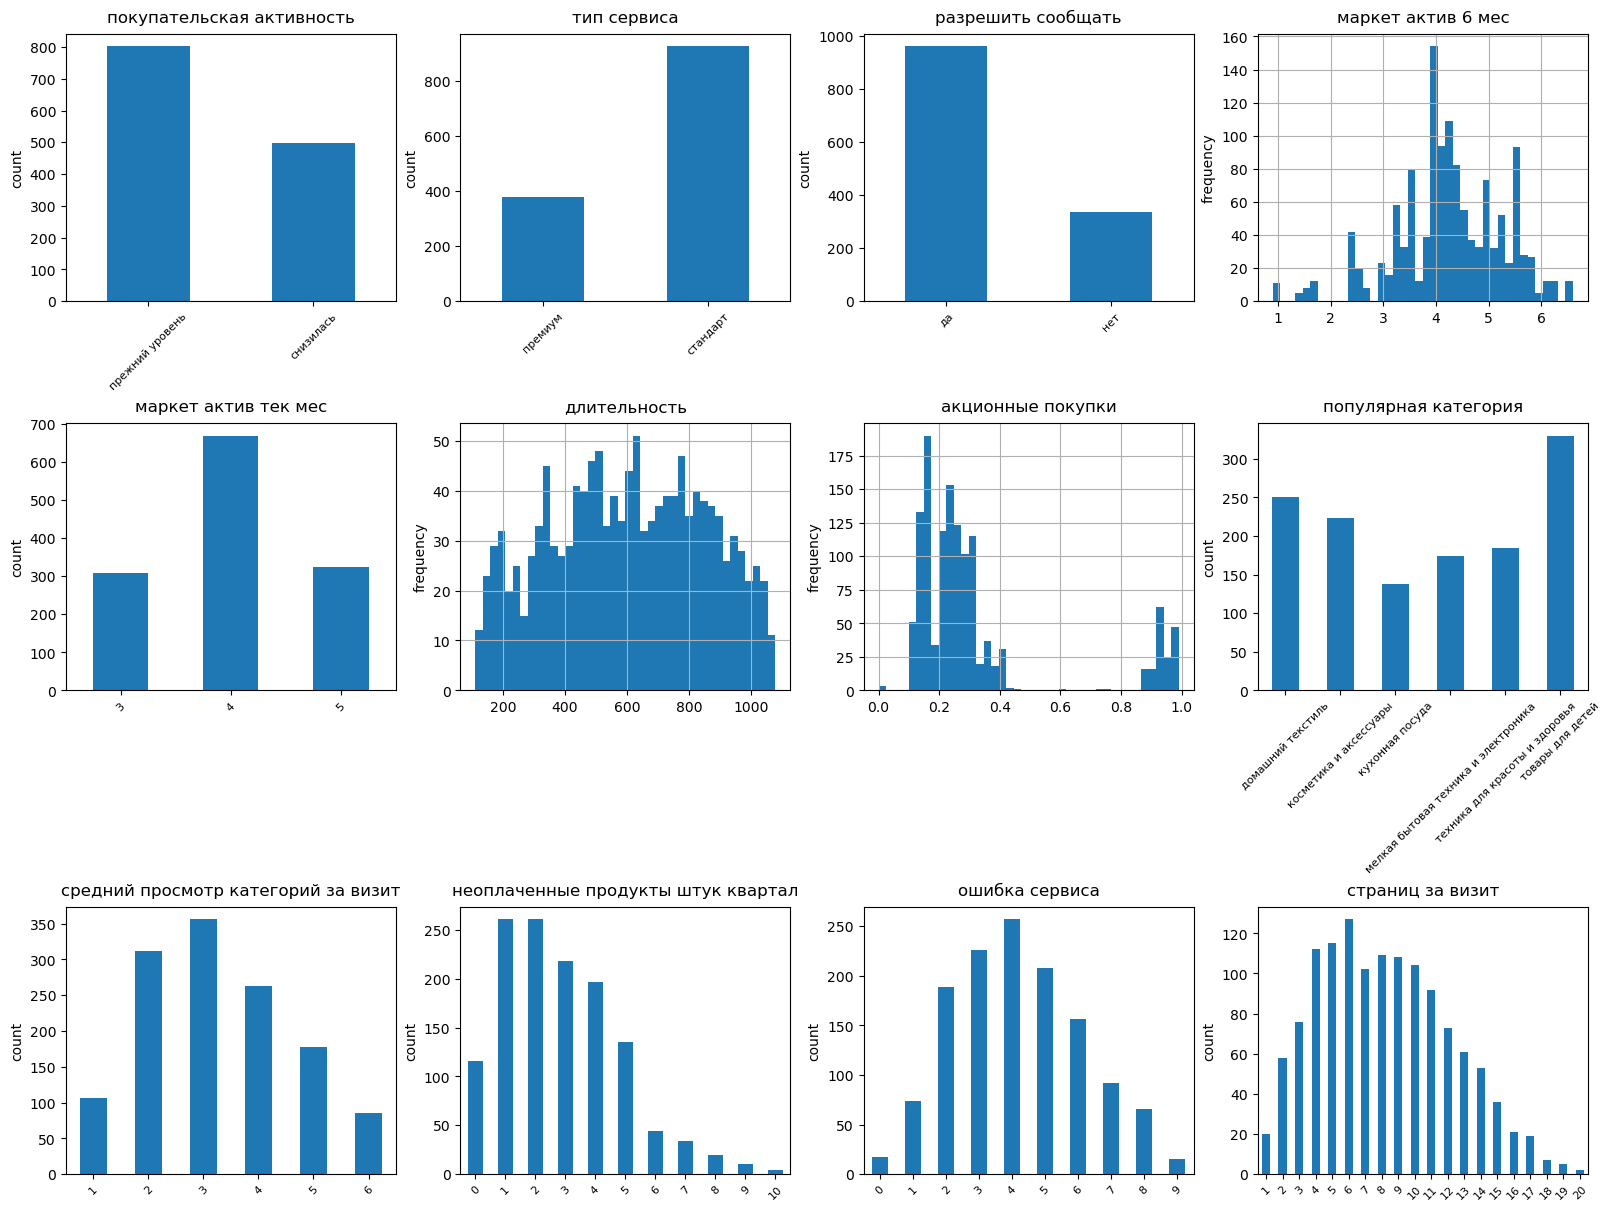

In [23]:
df = market_customer_df.drop('id', axis=1)

bar_cols = [
    'маркет актив тек мес',
    'средний просмотр категорий за визит',
    'неоплаченные продукты штук квартал',
    'ошибка сервиса',
    'страниц за визит',
    'тип сервиса',
    'покупательская активность',
    'тип сервиса',
    'популярная категория',
    'разрешить сообщать'

]

num_cols = [
    'маркет актив 6 мес',
    'длительность',
    'акционные покупки',
    'страниц за визит',
    'ошибка сервиса'
]

n_plots = len(df.columns)
n_cols = 4
n_rows = math.ceil(n_plots / n_cols)

fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(4*n_cols, 4*n_rows),
                         constrained_layout=True)

axes = axes.flatten()
for ax, col in zip(axes, df.columns):
    if col in bar_cols:
        df[col].value_counts().sort_index()\
             .plot(kind='bar', ax=ax)
        ax.set_title(col, pad=8)
        ax.set_ylabel("count")
        ax.tick_params(axis='x', rotation=45, labelsize=8)
    else:
        df[col].hist(bins=40, ax=ax)
        ax.set_title(col, pad=8)
        ax.set_ylabel("frequency")
    ax.set_xlabel("")

for ax in axes[n_plots:]:
    ax.set_visible(False)

plt.show()


In [24]:
 results = []
for col in num_cols:
    x = df[col].dropna()
    stat_sw, p_sw = stats.shapiro(x)
    stat_dn, p_dn = stats.normaltest(x)
    results.append({
        'feature': col,
        'p_shapiro': p_sw,
        'p_dagostino': p_dn
    })

res_df = pd.DataFrame(results)
normal_sw = res_df[res_df['p_shapiro'] > 0.05]
normal_dn = res_df[res_df['p_dagostino'] > 0.05]

print("По Shapiro–Wilk нормально распределены:", normal_sw['feature'].tolist())
print("По D’Agostino нормально распределены:", normal_dn['feature'].tolist())

По Shapiro–Wilk нормально распределены: []
По D’Agostino нормально распределены: []


1. **«Нормальные» распределения.**
   Не смотря на то, что некоторые показатели в данных выглядят близко к нормальному закону или совсем его напоминают, у нас нет численных столбцов с нормальным распределением

2. **Группировка по доле акционных покупок.**
   Всех покупателей разбили на две категории по тому, какова была их средняя месячная доля покупок по акции за последние полгода:

   * **Низкая активность по акциям**: доля акционных покупок ≤ 0,5.
   * **Высокая активность по акциям**: доля акционных покупок ≥ 0,8.

3. **Распределение «длительности».**
   Параметр `длительность` (количество дней от регистрации клиента до текущей даты) почти равномерно распределён, однако на гистограмме всё же заметен отчётливый пик.


In [25]:
real_num_cols = [
    'маркет актив 6 мес',
    'длительность',
    'акционные покупки']

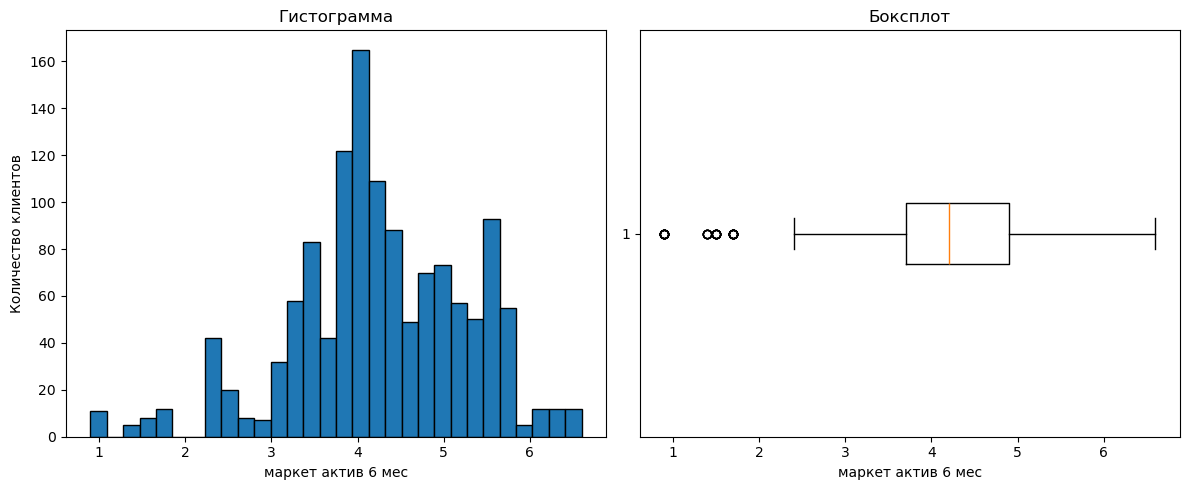

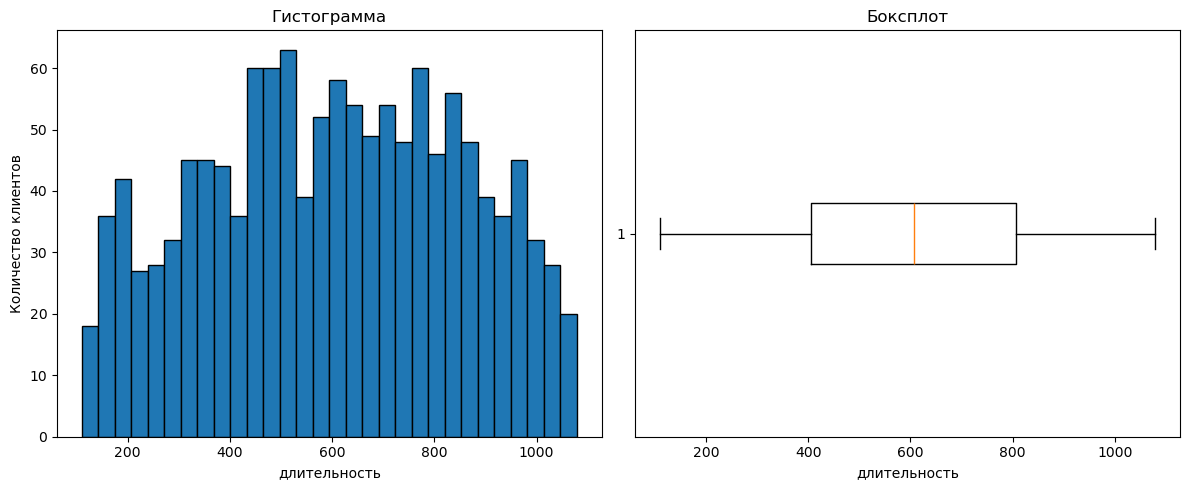

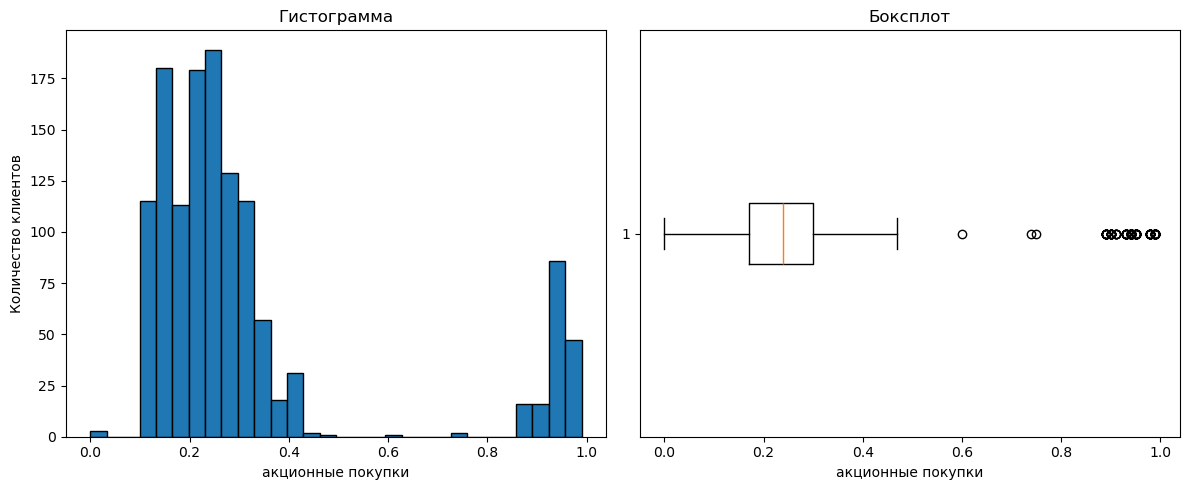

In [26]:
for col in real_num_cols:
    plot_column(market_customer_df[col])

Важно отметить, что не смотря на то, что некоторые графики боксплоты показывают "выбросы", я их таковыми назвать не могу, ибо все, что они показывают - в рамках возможных и реалистичных ситуаций.

* С некоторыми пользователяи магазин может почти не взаимодействовать
* Некоторые пользователи стремятся покупать ТОЛЬКО по акции
* Некоторые пользователи не очень сознательные и часто отменяют покупки пачками

Рассмотрю параметр за 6 месяцев чуть подробнее:

**Подвывод:**

* По доле акционных покупок покупателей за последние шесть месяцев выделены две группы: с среднемесячным показателем до 0,5 и с показателем свыше 0,8.
* Параметр `длительность` (число дней с момента регистрации на сайте) практически равномерно распределён, однако на гистограмме отчётливо виден один выраженный пик.
* При построении боксплота для столбца `маркет_актив_6_мес` обнаружено 36 выбросов за границами усов, но они сконцентрированы в четырёх повторяющихся значениях, поэтому были сохранены в наборе данных.
* В выборке заметен дисбаланс классов, что потребует особого внимания при построении и настройке моделей.
* Среди клиентов с пониженной активностью основное снижение приходится на число просмотренных страниц и категорий. При этом среди «падающих» пользователей выше доля любителей акционных предложений, что может указывать на их склонность к сокращению покупок. Высокое количество неоплаченных товаров также может служить сигналом об усталости или потере интереса к покупкам.


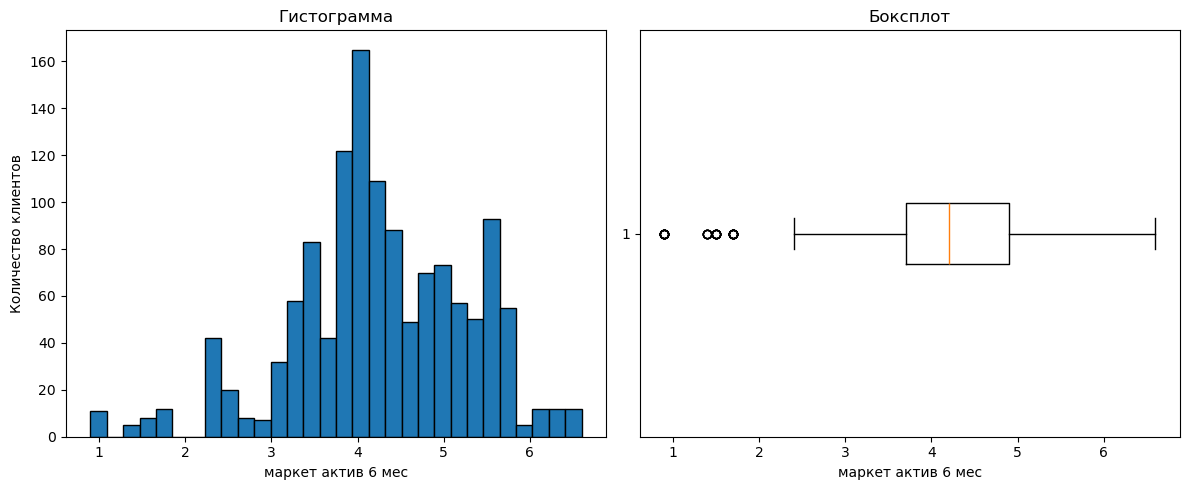

Количество "выбросов": 36


In [27]:

    plot_column(market_customer_df['маркет актив 6 мес'])
    outliers_count = market_customer_df[
        market_customer_df['маркет актив 6 мес'] < 2
    ]['id'].count()
    
    print(f'Количество "выбросов": {outliers_count}')

In [28]:
market_customer_df[
        market_customer_df['маркет актив 6 мес'] < 2
    ]['маркет актив 6 мес'].value_counts()

маркет актив 6 мес
1.7    12
0.9    11
1.5     8
1.4     5
Name: count, dtype: int64

Несмотря на небольшое количество выбросов, я оставляю их в данных: они не разбросаны случайно, а сгруппированы в четыре повторяющихся значения (см. `value_counts()`), что указывает на существенную закономерность, которую не стоит терять.


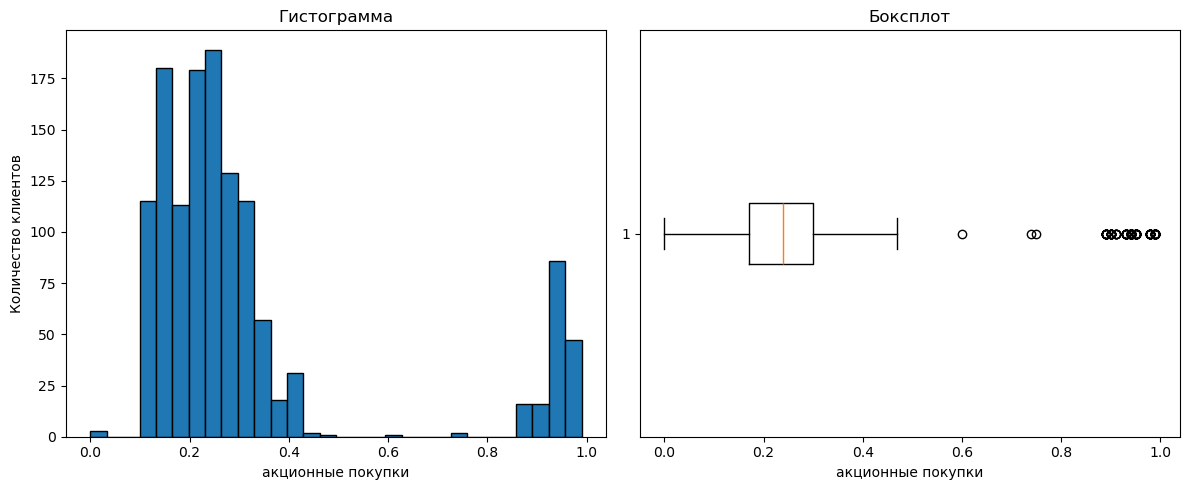

Количество "выбросов": 168


In [29]:

    plot_column(market_customer_df['акционные покупки'])
    outliers_count = market_customer_df[
        market_customer_df['акционные покупки'] > 0.5
    ]['id'].count()
    
    print(f'Количество "выбросов": {outliers_count}')

Не стану удалять эти выбросы, так как по гистограмме они формируют отдельный сегмент клиентов, регулярно совершающих акционные покупки.

Теперь проанализирую качественные признаки датасета:

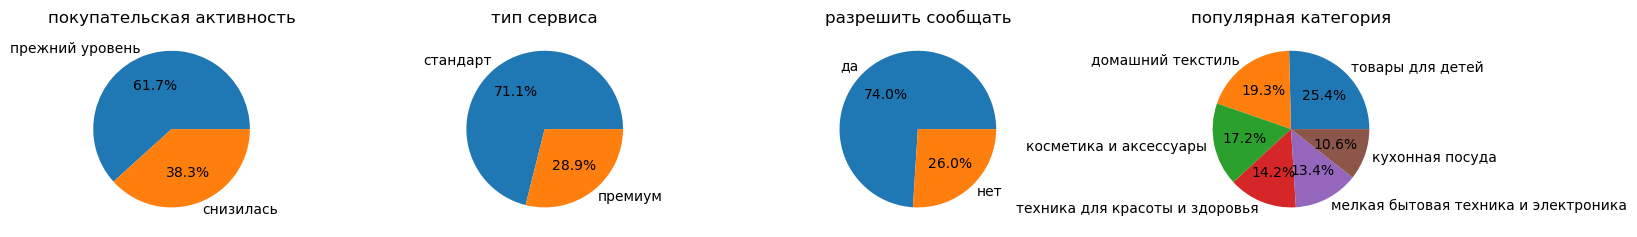

In [30]:
plot_categorical_pie_charts(market_customer_df)

### market_money_df<a id="10"></a>

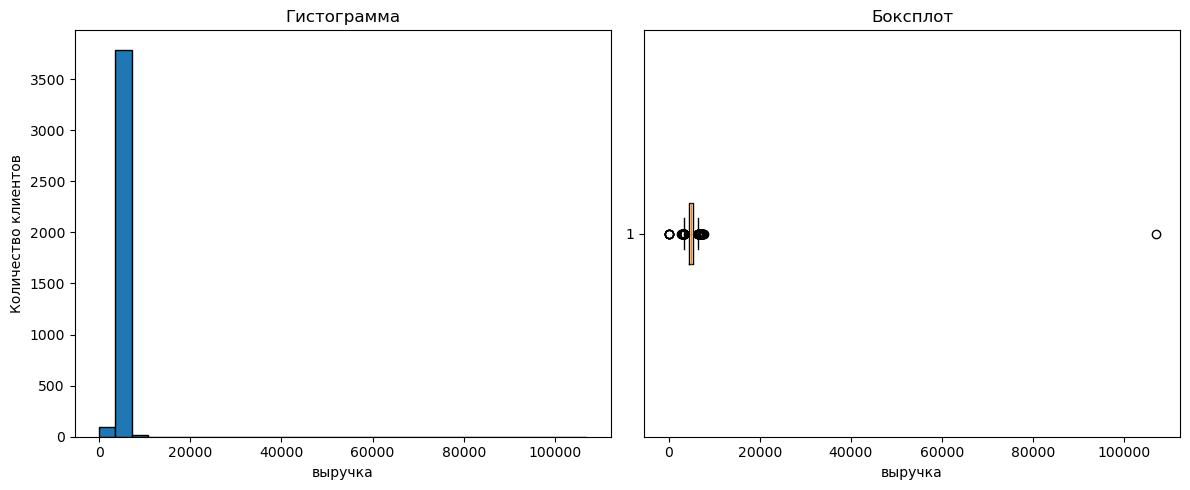

In [31]:
plot_column(market_money_df['выручка'])

Выглядит как аномалия, проверим

In [32]:
market_money_df.query('выручка > 40000')

,id,период,выручка
98,215380,текущий месяц,106862.2


In [33]:
market_money_df.query('id == 215380')

,id,период,выручка
96,215380,препредыдущий месяц,5051.0
97,215380,предыдущий месяц,6077.0
98,215380,текущий месяц,106862.2


Сначала заказывал на 5-6 тысяч, а потом сразу на 106... Лучше удалить этого пользователя. Хоть данные могут быть и правдивыми, модели ореинтироваться на них будет лишним

In [34]:
market_money_df = market_money_df.query('id != 215380')

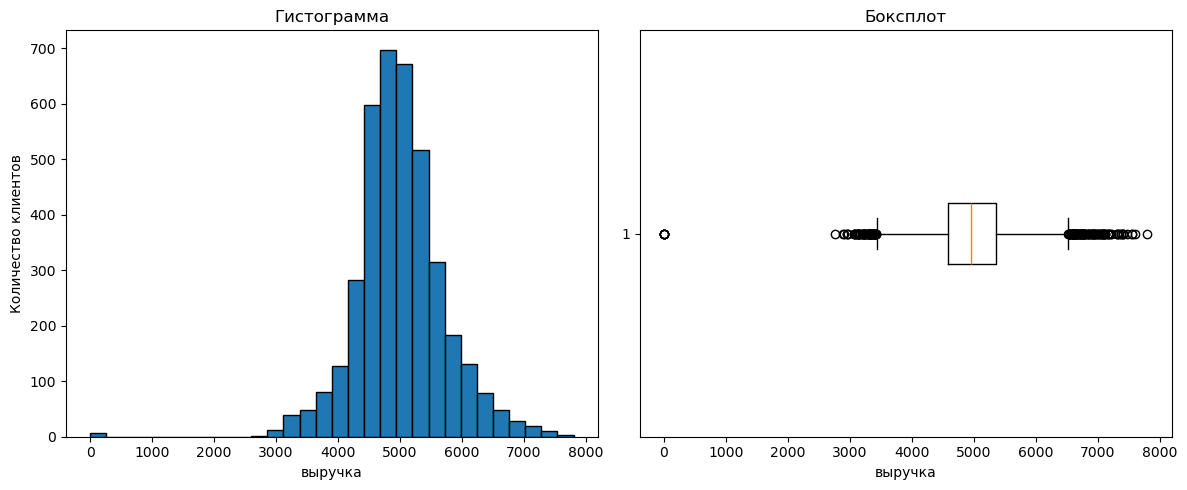

In [35]:
plot_column(market_money_df['выручка'])

Намного лучше. Данные о выручке сразу приняли почти идеальное симметричное нормальное распределение, однако есть и те, кто не принес никакой выручки. 

In [36]:
market_money_df.query('выручка == 0')

,id,период,выручка
0,215348,препредыдущий месяц,0.0
2,215348,предыдущий месяц,0.0
28,215357,препредыдущий месяц,0.0
29,215357,предыдущий месяц,0.0
34,215359,предыдущий месяц,0.0
35,215359,препредыдущий месяц,0.0


Удалим этих юзеров, если они не принесли выручки совсем

In [37]:
market_money_df.query('id in [215348,215357,215359]')

,id,период,выручка
0,215348,препредыдущий месяц,0.0
1,215348,текущий месяц,3293.1
2,215348,предыдущий месяц,0.0
27,215357,текущий месяц,5986.3
28,215357,препредыдущий месяц,0.0
29,215357,предыдущий месяц,0.0
33,215359,текущий месяц,4735.0
34,215359,предыдущий месяц,0.0
35,215359,препредыдущий месяц,0.0


Эти пользователи имеют пробелы в активности. Их удалим.

In [38]:
market_money_df = market_money_df.query('id not in [215348,215357,215359]')

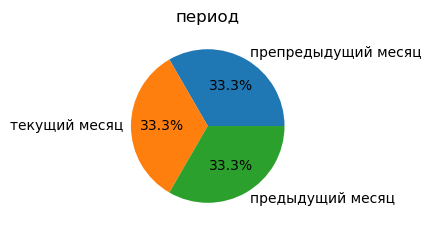

In [39]:
plot_categorical_pie_charts(market_money_df)

Круговая диаграмма показала очевидный результат.

### market_time_df<a id="11"></a>

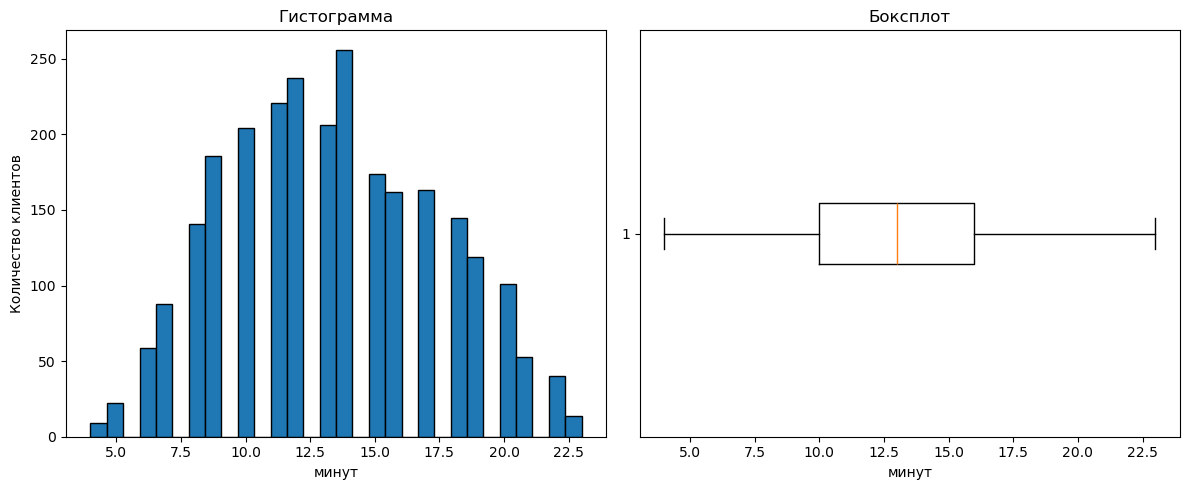

In [40]:
for col in list(market_time_df.drop('id', axis =1).select_dtypes(exclude = 'object').columns):
    plot_column(market_time_df[col])

Выбросов нет и данные выглядят гармонично

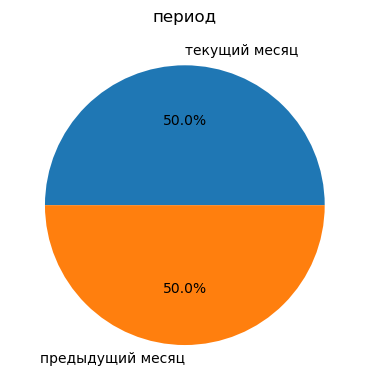

In [41]:
plot_categorical_pie_charts(market_time_df)

Ожидаемо.

### money_df<a id="12"></a>

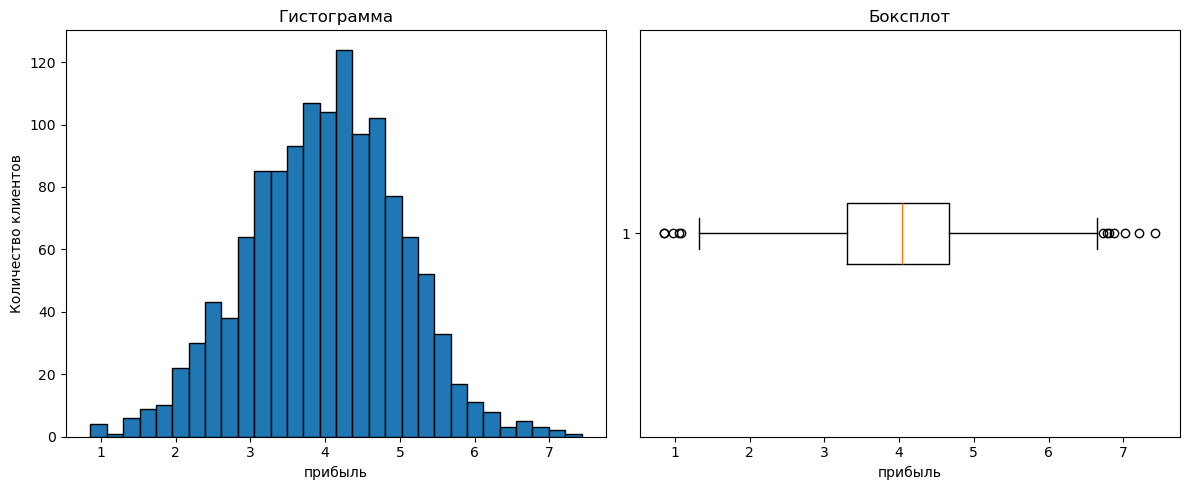

In [42]:
for col in list(money_df.drop('id', axis =1).select_dtypes(exclude = 'object').columns):
    plot_column(money_df[col])

### Сравнительный анализ<a id="13"></a>

Сначала построю гистограммы для непрерывных численных признаков

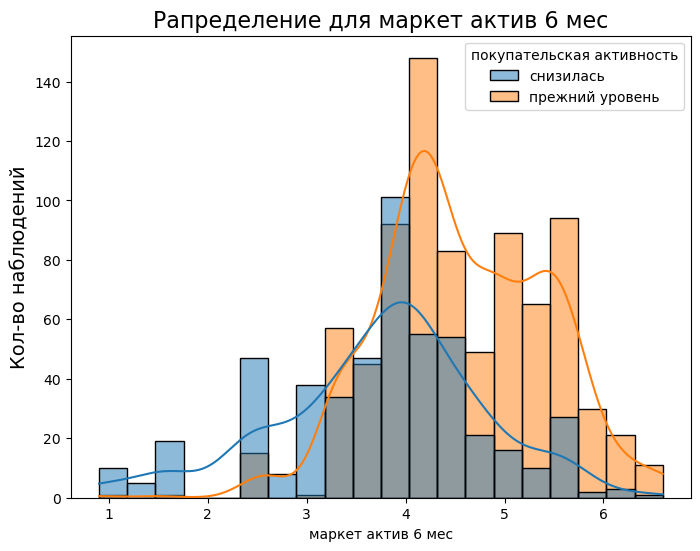

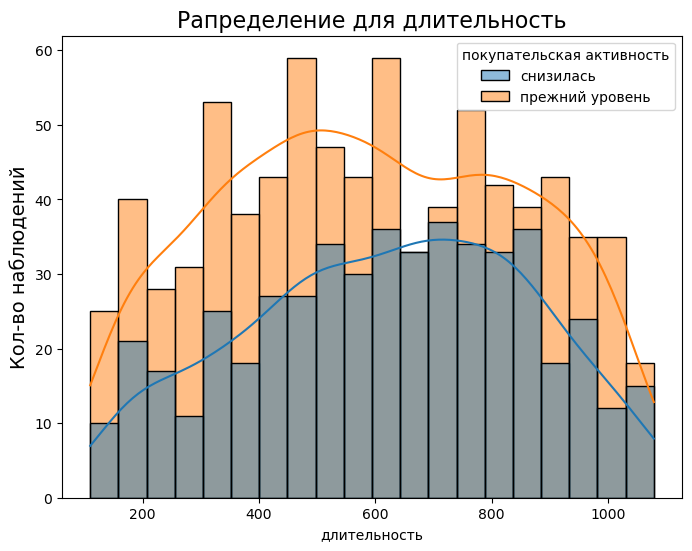

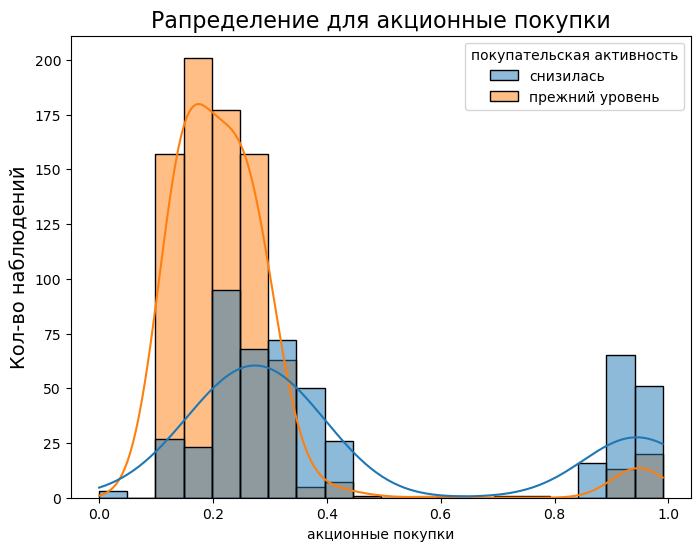

In [43]:
for i in real_num_cols:
    plot_hist(market_customer_df, i, 'покупательская активность')

In [44]:
for i in bar_cols:
    print()
    display(market_customer_df[i].value_counts(sort = True, normalize = True))

маркет актив тек мес
4    0.514615
5    0.248462
3    0.236923
Name: proportion, dtype: float64

средний просмотр категорий за визит
3    0.273846
2    0.240000
4    0.202308
5    0.136154
1    0.081538
6    0.066154
Name: proportion, dtype: float64

неоплаченные продукты штук квартал
2     0.200769
1     0.200769
3     0.167692
4     0.151538
5     0.103846
0     0.089231
6     0.033846
7     0.026154
8     0.015385
9     0.007692
10    0.003077
Name: proportion, dtype: float64

ошибка сервиса
4    0.197692
3    0.173846
5    0.160000
2    0.145385
6    0.120000
7    0.070769
1    0.056923
8    0.050769
0    0.013077
9    0.011538
Name: proportion, dtype: float64

страниц за визит
6     0.097692
5     0.088462
4     0.086154
8     0.083846
9     0.083077
10    0.080000
7     0.078462
11    0.070769
3     0.058462
12    0.056154
13    0.046923
2     0.044615
14    0.040769
15    0.027692
16    0.016154
1     0.015385
17    0.014615
18    0.005385
19    0.003846
20    0.001538
Name: proportion, dtype: float64

тип сервиса
стандарт    0.710769
премиум     0.289231
Name: proportion, dtype: float64

покупательская активность
прежний уровень    0.616923
снизилась          0.383077
Name: proportion, dtype: float64

тип сервиса
стандарт    0.710769
премиум     0.289231
Name: proportion, dtype: float64

популярная категория
товары для детей                        0.253846
домашний текстиль                       0.193077
косметика и аксессуары                  0.171538
техника для красоты и здоровья          0.141538
мелкая бытовая техника и электроника    0.133846
кухонная посуда                         0.106154
Name: proportion, dtype: float64

разрешить сообщать
да     0.74
нет    0.26
Name: proportion, dtype: float64

Клиенты, чья активность снизилась, стали просматривать меньше страниц за визит и реже переходить в разные категории товара – другими словами, они значительно сократили изучение сайта.

При этом в группе с пониженной активностью оказалась непропорционально большая доля покупателей, активно пользующихся акциями, что может свидетельствовать о том, что любители скидок более склонны к спаду в своих покупательских привычках.

Кроме того, среди «ухудшивших» свою активность пользователей чаще встречаются высокие значения признака `неоплаченные_продукты_штук_квартал`, что, по-видимому, тоже указывает на снижение их вовлечённости в покупки.


## Объединение таблиц<a id="15"></a>

In [45]:
for entry in dfs:
    display(entry.head(2))

,id,покупательская активность,тип сервиса,разрешить сообщать,маркет актив 6 мес,маркет актив тек мес,длительность,акционные покупки,популярная категория,средний просмотр категорий за визит,неоплаченные продукты штук квартал,ошибка сервиса,страниц за визит
0,215348,снизилась,премиум,да,3.4,5,121,0.00,товары для детей,6,2,1,5
1,215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5


,id,период,выручка
0,215348,препредыдущий месяц,0.0
1,215348,текущий месяц,3293.1


,id,период,минут
0,215348,текущий месяц,14
1,215348,предыдущий месяц,13


,id,прибыль
0,215348,0.98
1,215349,4.16


В ходе исследовательского анализа данных мы удаляли некоторые столбцы. Удалим их из всех датасетов (хотя left join и решили бы эту проблему, но мне так спокойнее)

In [46]:
deleted_id_list = [215348,215357,215359, 215380]

for entry in dfs:
    entry = entry.query('id not in @deleted_id_list')

In [47]:
# 1) pivot выручки по столбцу 'период'
money_wide = (
    market_money_df
    .pivot(index='id', columns='период', values='выручка')
    .rename(columns={
        'предыдущий месяц': 'выручка пред',
        'текущий месяц':    'выручка тек',
        'препредыдущий месяц': 'выручка препред'
    })
    .reset_index()
)

# 2) pivot времени по сайту по тому же 'период'
time_wide = (
    market_time_df
    .pivot(index='id', columns='период', values='минут')
    .rename(columns={
        'предыдущий месяц': 'минут пред',
        'текущий месяц':    'минут тек'
    })
    .reset_index()
)

# 3) объединяем с customer-таблицей
merged = (
    market_customer_df
    .merge(money_wide, on='id', how='left')
    .merge(time_wide,  on='id', how='left')
)
merged.set_index('id', inplace=True)
display(merged.head())


,покупательская активность,тип сервиса,разрешить сообщать,маркет актив 6 мес,маркет актив тек мес,длительность,акционные покупки,популярная категория,средний просмотр категорий за визит,неоплаченные продукты штук квартал,ошибка сервиса,страниц за визит,выручка пред,выручка препред,выручка тек,минут пред,минут тек
id,,,,,,,,,,,,,,,,,
215348,снизилась,премиум,да,3.4,5,121,0.00,товары для детей,6,2,1,5,NaN,NaN,NaN,13,14
215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
215351,снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11


In [48]:
market_file = merged.query('id not in @deleted_id_list')

In [49]:
market_file[['минут тек', 'минут пред', 'выручка тек', 'выручка пред', 'выручка препред']]

,минут тек,минут пред,выручка тек,выручка пред,выручка препред
id,,,,,
215349,10,12,4971.6,5216.0,4472.0
215350,13,8,5058.4,5457.5,4826.0
215351,13,11,6610.4,6158.0,4793.0
215352,11,8,5872.5,5807.5,4594.0
215353,10,10,5388.5,4738.5,5124.0
...,...,...,...,...,...
216643,7,14,4741.7,3664.0,4704.0
216644,11,12,5353.0,4729.0,5299.0
216645,18,12,5139.2,5160.0,5334.0


In [50]:
market_file.sample(5)

,покупательская активность,тип сервиса,разрешить сообщать,маркет актив 6 мес,маркет актив тек мес,длительность,акционные покупки,популярная категория,средний просмотр категорий за визит,неоплаченные продукты штук квартал,ошибка сервиса,страниц за визит,выручка пред,выручка препред,выручка тек,минут пред,минут тек
id,,,,,,,,,,,,,,,,,
215985,прежний уровень,стандарт,да,5.5,5,541,0.17,мелкая бытовая техника и электроника,4,1,6,5,5388.0,5223.0,5661.0,12,11
216587,прежний уровень,стандарт,да,4.4,3,286,0.19,товары для детей,4,0,7,14,5265.5,4895.0,5716.6,10,17
216638,прежний уровень,стандарт,нет,1.5,3,930,0.29,мелкая бытовая техника и электроника,2,0,4,16,3234.0,4613.0,4557.4,11,14
216373,прежний уровень,стандарт,да,4.2,4,651,0.12,техника для красоты и здоровья,3,1,2,10,4135.0,4940.0,4963.1,10,7
216390,прежний уровень,стандарт,да,6.1,5,876,0.17,товары для детей,3,3,5,8,3931.0,4754.0,4774.7,11,12


Таблицы успешно соединены

## Корреляционный анализ<a id="16"></a>

In [51]:
market_file.corr(method='spearman', numeric_only=True)\
           .style.background_gradient(cmap='coolwarm')


,маркет актив 6 мес,маркет актив тек мес,длительность,акционные покупки,средний просмотр категорий за визит,неоплаченные продукты штук квартал,ошибка сервиса,страниц за визит,выручка пред,выручка препред,выручка тек,минут пред,минут тек
маркет актив 6 мес,1.000000,0.061741,-0.044445,-0.276590,0.185013,-0.135045,0.038643,0.319872,-0.003642,0.234728,0.002093,0.273727,0.226968
маркет актив тек мес,0.061741,1.000000,-0.131967,0.033099,-0.025167,0.061747,0.087343,0.003143,-0.027088,-0.039437,-0.011782,0.013535,-0.063051
длительность,-0.044445,-0.131967,1.000000,0.029045,-0.043154,-0.108787,0.103562,-0.034495,0.013537,-0.039301,0.015002,-0.123940,0.083048
акционные покупки,-0.276590,0.033099,0.029045,1.000000,-0.203401,0.198307,-0.051593,-0.370860,0.005184,-0.269087,0.022255,-0.332548,-0.275313
средний просмотр категорий за визит,0.185013,-0.025167,-0.043154,-0.203401,1.000000,-0.251559,0.010034,0.267479,-0.049460,0.149742,-0.070716,0.148279,0.233369
неоплаченные продукты штук квартал,-0.135045,0.061747,-0.108787,0.198307,-0.251559,1.000000,-0.098582,-0.165412,0.033434,-0.249293,0.061178,-0.183575,-0.214699
ошибка сервиса,0.038643,0.087343,0.103562,-0.051593,0.010034,-0.098582,1.000000,0.104482,0.035476,0.090152,0.040477,0.196009,0.078074
страниц за визит,0.319872,0.003143,-0.034495,-0.370860,0.267479,-0.165412,0.104482,1.000000,-0.067610,0.311675,-0.049964,0.450760,0.298120
выручка пред,-0.003642,-0.027088,0.013537,0.005184,-0.049460,0.033434,0.035476,-0.067610,1.000000,0.308041,0.879097,-0.084215,-0.083214
выручка препред,0.234728,-0.039437,-0.039301,-0.269087,0.149742,-0.249293,0.090152,0.311675,0.308041,1.000000,0.149944,0.348745,0.299783


1. Попарные корреляции между независимыми фичами не превышают |0.7|, поэтому серьёзного мультиколлинеарного эффекта нет.
2. Максимальное значение ≈ 0.36 наблюдается между «минут тек» и «минут пред», что далеко ниже критических порогов.
3. Единственная очень сильная связь (≈ 0.88) — между «выручка пред» и «выручка тек», но это не показатель коллинеарности входных переменных, а закономерность прогноз
4. Не буду покамест ничего удалятьях.


## Использование пайплайнов и итоговая модель<a id="17"></a>

In [52]:
market_file.head()

,покупательская активность,тип сервиса,разрешить сообщать,маркет актив 6 мес,маркет актив тек мес,длительность,акционные покупки,популярная категория,средний просмотр категорий за визит,неоплаченные продукты штук квартал,ошибка сервиса,страниц за визит,выручка пред,выручка препред,выручка тек,минут пред,минут тек
id,,,,,,,,,,,,,,,,,
215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
215351,снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
215353,снизилась,стандарт,да,3.3,4,762,0.26,домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


In [53]:
le = LabelEncoder()
le.fit(market_file['покупательская активность'])
y_enc = le.transform(market_file['покупательская активность'])
y_enc = 1 - y_enc

market_file['покупательская активность'] = y_enc


market_file['акционные покупки'] = (market_file['акционные покупки']
                                    .apply(lambda x: 'редко' if x <= 0.65 else 'часто'))

print(market_file['покупательская активность'].value_counts())

market_file['акционные покупки'].value_counts()

покупательская активность
1    802
0    494
Name: count, dtype: int64


акционные покупки
редко    1130
часто     166
Name: count, dtype: int64

Наш целевой признак - покупательская активность.

Разбиваем на тренировочную и тестовую выборки с учетом дисбаланса классов

In [54]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    market_file.drop(['покупательская активность'], axis= 1),
    market_file['покупательская активность'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = market_file['покупательская активность']
)

In [55]:
ohe_columns = ['популярная категория', 'разрешить сообщать']
ord_columns = ['акционные покупки', 'тип сервиса']

num_columns = list(market_file.drop('покупательская активность', axis = 1).select_dtypes(exclude = 'object').columns)
num_columns

['маркет актив 6 мес',
 'маркет актив тек мес',
 'длительность',
 'средний просмотр категорий за визит',
 'неоплаченные продукты штук квартал',
 'ошибка сервиса',
 'страниц за визит',
 'выручка пред',
 'выручка препред',
 'выручка тек',
 'минут пред',
 'минут тек']

Данные разделили, будем писать пайплайн. Нам подойдет метрика качества ROC-AUC для оценка модели вне зависимости от порогов классификации, а еще она устойчива к дизбалансу классов.

In [56]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(handle_unknown='ignore'))  
    ]
)

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')),
     ('ord', OrdinalEncoder(categories = [['редко', 'часто'],
                                         ['стандарт', 'премиум']],
                           handle_unknown = 'use_encoded_value', unknown_value = np.nan)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
        
    ]
)

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)    
    ],
    remainder='passthrough'
)

pipe_final = Pipeline(
    [('preprocessor', data_preprocessor),
     ('models', LogisticRegression(random_state = RANDOM_STATE))  
    ]
)

param_grid = [
    {
        'models' : [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,6),
        'models__max_features' : range(2,6),
        'preprocessor__num' : [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models' : [LogisticRegression(random_state = RANDOM_STATE, class_weight = 'balanced')],
        'models__C' : range(1, 5),
        'models__penalty' : ['l1','l2'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models' : [KNeighborsClassifier()],
        'models__n_neighbors' : range(2,6),
        'preprocessor__num' : [StandardScaler(), MinMaxScaler(), 'passthrough']},
    {
        'models' : [SVC(random_state = RANDOM_STATE, probability=True)],
        'models__kernel' : ['rbf', 'linear', 'sigmoid', 'poly'],
        'models__degree' : range(1,10),
        'models__C' : range(1, 5)
    }
    
]

randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv = 5,
    scoring= 'roc_auc',
    random_state = RANDOM_STATE,
    n_jobs = 1,
)

randomized_search.fit(X_train,y_train)


,estimator,Pipeline(step...m_state=42))])
,param_distributions,"[{'models': [DecisionTreeC...ndom_state=42)], 'models__max_depth': range(2, 6), 'models__max_features': range(2, 6), 'preprocessor__num': [StandardScaler(), MinMaxScaler(), ...]}, {'models': [LogisticRegre...ndom_state=42)], 'models__C': range(1, 5), 'models__penalty': ['l1', 'l2'], 'preprocessor__num': [StandardScaler(), MinMaxScaler(), ...]}, ...]"
,n_iter,10
,scoring,'roc_auc'
,n_jobs,1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [57]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кроссвалидации:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['популярная категория',
                                                   'разрешить сообщать']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_fre...
                                

Метрика на кросс-валидации дала результат 0.9, что является отличным результатом. Лучше всего справилась SCV со значением C = 4. Ниже я выведу лучшие показатели модели:

In [58]:
randomized_search.best_params_

{'models__kernel': 'rbf',
 'models__degree': 3,
 'models__C': 4,
 'models': SVC(probability=True, random_state=42)}

In [59]:
y_test_pred_proba = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred_proba[:,1])}')

Метрика ROC-AUC на тестовой выборке: 0.9022983870967742


**Подвывод:**

1) В пайплайне были добавлены сегменты для преобразования численных, порядковых и категориальных данных.
2) В пайплайне были добавлены четыре модели машинного обучения: DecisionTreeClassifier, LogisticRegression, KNeighborsClassifier, SVC
3) На кросс-валидации было получено значение метрики ROC-AUC approx. 0.9, что является отличным результатом
4) На тестовой выборке было получено значение ROC-AUC 0.91 

## Анализ важностей признаков<a id="18"></a>

Выведу преобразованные признаки:

In [60]:
X_train2 = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
X_test2 = pipe_final.named_steps['preprocessor'].transform(X_test)

ohe_feature_names = (pipe_final.named_steps['preprocessor'].transformers_[0][1]
                     .named_steps['ohe'].get_feature_names_out(ohe_columns).tolist())

columns = ohe_feature_names + ord_columns + num_columns

In [61]:
X_train2 = pd.DataFrame(X_train2, columns = columns)


X_test2 = pd.DataFrame(X_train2, columns = columns)
X_test2

,популярная категория_домашний текстиль,популярная категория_косметика и аксессуары,популярная категория_кухонная посуда,популярная категория_мелкая бытовая техника и электроника,популярная категория_техника для красоты и здоровья,популярная категория_товары для детей,разрешить сообщать_да,разрешить сообщать_нет,акционные покупки,тип сервиса,...,длительность,средний просмотр категорий за визит,неоплаченные продукты штук квартал,ошибка сервиса,страниц за визит,выручка пред,выручка препред,выручка тек,минут пред,минут тек
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.140932,1.300196,-0.916299,-0.077381,0.963226,-0.976982,0.565381,-1.803557,-0.398744,1.118730
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-1.007186,1.300196,-0.916299,0.945945,-0.047849,-0.856667,0.343539,-0.274983,0.364207,-0.069691
2,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,-0.169267,-0.196300,0.086677,1.457608,-1.058924,0.440615,-0.357961,0.477419,-1.416011,-1.020428
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-1.812722,2.048444,0.588165,-1.100708,-0.806155,-0.974151,-0.855607,-0.735148,-1.416011,-0.307376
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.238082,0.551948,-0.916299,0.945945,-0.806155,0.630996,1.164954,0.510577,-0.398744,-0.545060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.118135,0.551948,-0.916299,1.457608,1.974300,0.178752,-0.597790,0.407420,0.364207,-0.069691
968,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.761590,1.300196,-0.414811,1.457608,-0.806155,0.356394,-0.468882,0.641543,0.872840,1.594098
969,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.733419,-0.196300,-0.916299,0.945945,0.204919,-0.148930,0.034759,-0.323472,0.109890,-0.545060
970,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,-1.229822,-0.196300,1.089653,-1.100708,1.721532,0.268635,-0.304000,0.385553,1.381474,-0.782744


Оставлю только лучшую модель и сделаю случайные выборки из X_train2 и X_test2, чтобы KernelExplainer работал быстрее.

In [62]:
best_model = randomized_search.best_estimator_.named_steps['models']
X_train_sample = shap.sample(X_train2, 100, random_state = RANDOM_STATE)
X_test_sample = shap.sample(X_test2, 100, random_state = RANDOM_STATE)
X_test_sample

,популярная категория_домашний текстиль,популярная категория_косметика и аксессуары,популярная категория_кухонная посуда,популярная категория_мелкая бытовая техника и электроника,популярная категория_техника для красоты и здоровья,популярная категория_товары для детей,разрешить сообщать_да,разрешить сообщать_нет,акционные покупки,тип сервиса,...,длительность,средний просмотр категорий за визит,неоплаченные продукты штук квартал,ошибка сервиса,страниц за визит,выручка пред,выручка препред,выручка тек,минут пред,минут тек
767,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.834617,-0.196300,1.089653,1.969272,-0.553387,1.237527,-0.235049,0.528522,-0.907377,-0.545060
70,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,1.239409,0.551948,1.089653,-0.589044,0.963226,-0.314540,1.045040,-0.930646,0.364207,-0.782744
855,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.101943,-0.196300,0.086677,1.457608,-0.806155,0.294821,1.473735,-0.122387,-0.144427,0.167993
485,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,-1.739860,0.551948,1.089653,-0.589044,0.710457,0.400982,0.016772,0.544566,1.890108,1.594098
644,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.007350,-0.944548,0.086677,0.434282,-0.806155,0.678415,-0.636763,0.128612,-1.161694,-0.307376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.474352,-0.944548,1.591141,1.457608,-1.311693,-2.592039,-1.155393,-2.334552,-0.907377,-1.020428
603,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.077492,2.048444,-0.414811,-0.077381,0.963226,-1.204874,-0.393936,-1.831129,0.109890,0.167993
716,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.745562,2.048444,0.588165,-1.100708,-0.047849,0.783868,0.481441,-0.047040,0.364207,1.118730
825,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,-0.371663,-0.944548,-0.916299,0.945945,-0.047849,0.960802,-0.465884,1.587780,0.872840,1.118730


In [63]:
explainer = shap.KernelExplainer(best_model.predict, X_train_sample)
shap_values = explainer(X_test_sample)

  0%|          | 0/100 [00:00<?, ?it/s]

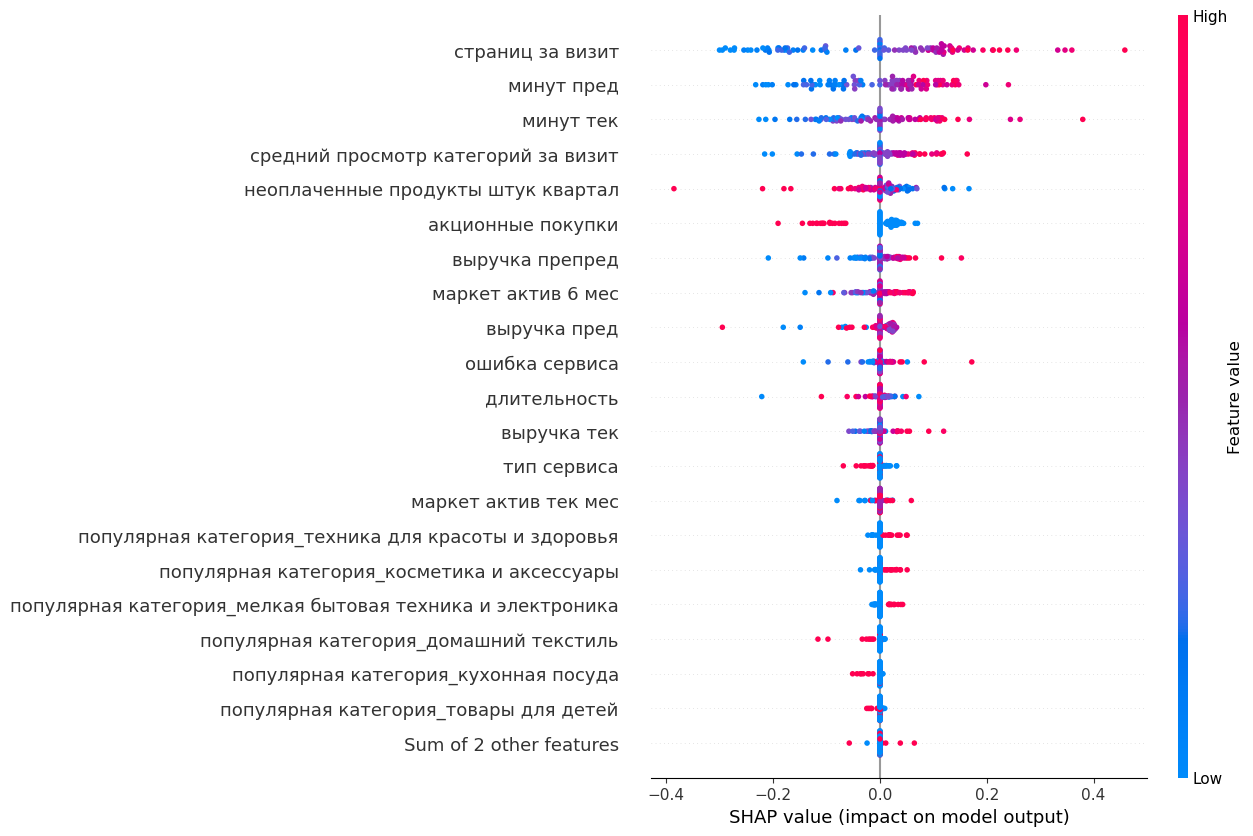

In [64]:
shap.plots.beeswarm(shap_values, max_display = 21) 

1. Самое влиятельное – вовлечённость пользователя: количество просмотренных страниц за визит и время, проведённое на сайте. Чем больше этих показателей, тем выше вероятность целевого действия.
2. Среднее число просмотров разных категорий за визит тоже положительно коррелирует с конверсией: пользователи, активно изучающие ассортимент, чаще совершают целевое действие.
3. Обратная связь с «брошенными» товарами важна: если за квартал накопилось много неоплаченных позиций, то шансы на покупку снижаются.
4. Акции работают не так эффективно: частые «акционные» покупки дают небольшой отрицательный вклад в конверсию, вероятно, эти клиенты больше ждут скидок и реже покупают по обычным ценам.
5. История выручки по предыдущим периодам умеренно влияет – более высокие продажи в прошлом слегка повышают вероятность покупки сегодня.
6. Технические нюансы (флаг ошибки сервиса, длительность сессии) и категориальные маркеры (тип сервиса, популярность конкретных товарных категорий) имеют малозначимый эффект и практически не меняют прогноз модели.

В итоге модель главным образом обращает внимание на реальные действия и поведение пользователя на сайте, а не на формальные категориальные признаки.


Подготовлю барплот пермутационной вавжности признакв

1. Вовлечённость по-прежнему на первом месте: количество страниц за визит и время, проведённое на сайте (минут пред и минут тек), задают почти 50 % прогноза — чем выше эти показатели, тем больше вероятность цели.
2. Средний просмотр категорий за визит даёт заметный положительный вклад: активный поиск товаров сильно помогает довести пользователя до покупки.
3. «Брошенные» в корзине товары (неоплаченные продукты штук за квартал) снижают конверсию примерно на том же уровне, что и средний просмотр: клиенты, часто забывающие оформить заказ, реже возвращаются за покупкой.
4. Акционные покупки слегка подрывают эффективность обычных продаж: высокая доля скидочных заказов даёт небольшой отрицательный эффект на общую конверсию.
5. Финансовые показатели (выручка за препред, пред и текущий периоды, а также активность на маркетплейсе за 6 мес) влияют умеренно — стабильный рост оборота в прошлом даёт небольшой плюс к вероятности новой покупки.
6. Технические флаги (ошибка сервиса, длительность сессии) и категориальные индикаторы (популярность конкретных товарных категорий, тип сервиса, разрешения на рассылку) почти не влияют на прогноз и могут быть убраны или сведены к минимуму.


## Сегментация покупателей<a id="19"></a>

Есть предположение о том, что любители акционных покупок склонны снижать свою покупательскую активность. Мы можем проверить это предположение при помощи данных:

Попробуем предсказать значение класса 0 (активность снизится):

In [66]:
test_proba = randomized_search.predict_proba(X_test)[:,0]
test = X_test.copy()
test['снизилась активность вероятность'] = test_proba
money = money_df.set_index('id')
test = test.join(money)
display(test.head(2))

train_proba = randomized_search.predict_proba(X_train)[:,0]
train = X_train.copy()
train['снизилась активность вероятность'] = train_proba
train = train.join(money)
display(train.head(2))

,тип сервиса,разрешить сообщать,маркет актив 6 мес,маркет актив тек мес,длительность,акционные покупки,популярная категория,средний просмотр категорий за визит,неоплаченные продукты штук квартал,ошибка сервиса,страниц за визит,выручка пред,выручка препред,выручка тек,минут пред,минут тек,снизилась активность вероятность,прибыль
id,,,,,,,,,,,,,,,,,,
215439,премиум,нет,3.4,5,448,редко,товары для детей,4,2,2,7,5484.0,4551.0,5833.7,9,9,0.830847,6.33
216575,премиум,да,4.5,4,482,редко,косметика и аксессуары,3,2,2,9,5567.0,5483.0,5769.8,8,22,0.031182,1.82


,тип сервиса,разрешить сообщать,маркет актив 6 мес,маркет актив тек мес,длительность,акционные покупки,популярная категория,средний просмотр категорий за визит,неоплаченные продукты штук квартал,ошибка сервиса,страниц за визит,выручка пред,выручка препред,выручка тек,минут пред,минут тек,снизилась активность вероятность,прибыль
id,,,,,,,,,,,,,,,,,,
215761,стандарт,нет,5.7,4,565,редко,домашний текстиль,5,1,4,12,4252.0,5023.0,3713.8,12,18,0.103639,2.60
216625,стандарт,да,3.4,5,351,редко,кухонная посуда,5,1,6,8,4337.0,4949.0,5000.0,15,13,0.042234,4.12


In [67]:
joined = pd.concat([train,test])

In [68]:
pivot = joined.pivot_table(index ='акционные покупки', values = 'снизилась активность вероятность', aggfunc = 'mean')
pivot['снизилась активность вероятность'] = pivot['снизилась активность вероятность'].round(4)
pivot

,снизилась активность вероятность
акционные покупки,
редко,0.3189
часто,0.7872


Действительно, предположение подтверждается

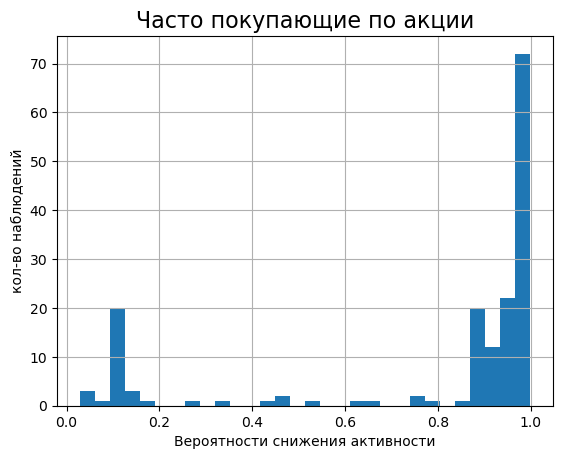

In [69]:
df1 = joined[joined['акционные покупки'] == 'часто']['снизилась активность вероятность']
plt.hist(df1, bins = 30)
plt.title('Часто покупающие по акции', fontdict = {'fontsize' : 16})
plt.xlabel('Вероятности снижения активности')
plt.ylabel('кол-во наблюдений')
plt.grid()

Очень большая группа тех, у кого значение вероятности превышает 0.7

In [70]:
qq = joined[joined['акционные покупки'] == 'часто']

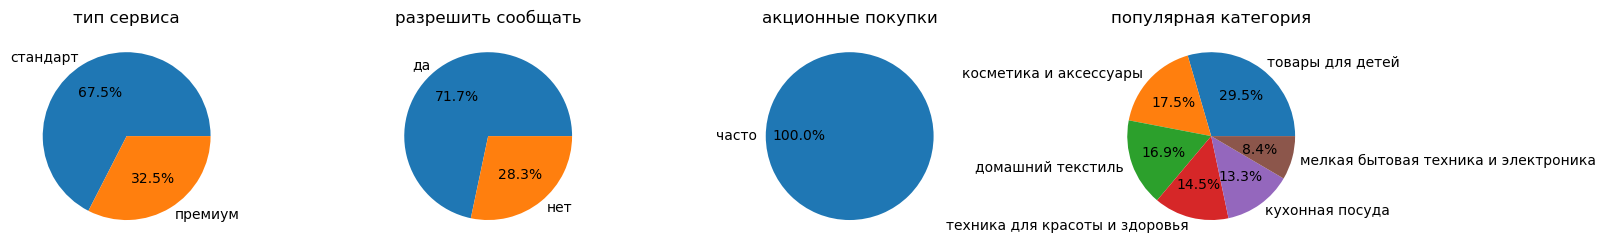

In [71]:
plot_categorical_pie_charts(qq)

**Подвывод**

Пользователи, которые собираются снизить свою активность обычно довольно экономны и выбирают тип сервиса "стандарт". Они также следят за скидками и акциями и в подовляющем случае подписаны на рассылку. Судя по всему это женщины и семьи с детьми. Возможно, стоит их приманивать скидками на категории товаров для женщин (это не сексизм) и детей.

Выделю группу пользователей, которые скорее всего уйдут. Как я ранее отмечал, у них вероятность > 0.7. Пускай это будут те, кто

In [72]:
qq['группа'] = joined.apply(lambda x: 'целевая' \
             if x['снизилась активность вероятность'] >= 0.7 \
             and x['акционные покупки'] == "часто" else 'нецелевая', axis = 1)

In [73]:
display(qq['группа'].value_counts(sort = True, normalize = True))

группа
целевая      0.783133
нецелевая    0.216867
Name: proportion, dtype: float64

Интересно то, что они не так критичны для бизнеса. Они не приносят больше денег, но при том являются меншинством. Стоит ли так сильно за них бороться и терять деньги - на откуп хозяина

In [74]:
bar_cols = ['маркет актив тек мес',
 'средний просмотр категорий за визит',
 'неоплаченные продукты штук квартал',
 'ошибка сервиса',
 'страниц за визит',
 'тип сервиса',
 'тип сервиса',
 'популярная категория',
 'разрешить сообщать']

In [75]:
for i in bar_cols:
    print()
    display(qq[i].value_counts(sort = True, normalize = True))

маркет актив тек мес
4    0.506024
3    0.259036
5    0.234940
Name: proportion, dtype: float64

средний просмотр категорий за визит
2    0.331325
3    0.271084
4    0.150602
1    0.138554
5    0.060241
6    0.048193
Name: proportion, dtype: float64

неоплаченные продукты штук квартал
4     0.156627
2     0.156627
1     0.138554
3     0.132530
5     0.114458
0     0.084337
6     0.072289
7     0.048193
8     0.048193
9     0.042169
10    0.006024
Name: proportion, dtype: float64

ошибка сервиса
3    0.228916
4    0.174699
2    0.168675
5    0.144578
6    0.114458
7    0.090361
8    0.042169
1    0.030120
0    0.006024
Name: proportion, dtype: float64

страниц за визит
4     0.162651
6     0.144578
3     0.132530
5     0.126506
2     0.126506
7     0.066265
10    0.042169
9     0.042169
13    0.036145
11    0.036145
8     0.024096
12    0.018072
1     0.018072
14    0.012048
15    0.012048
Name: proportion, dtype: float64

тип сервиса
стандарт    0.674699
премиум     0.325301
Name: proportion, dtype: float64

тип сервиса
стандарт    0.674699
премиум     0.325301
Name: proportion, dtype: float64

популярная категория
товары для детей                        0.295181
косметика и аксессуары                  0.174699
домашний текстиль                       0.168675
техника для красоты и здоровья          0.144578
кухонная посуда                         0.132530
мелкая бытовая техника и электроника    0.084337
Name: proportion, dtype: float64

разрешить сообщать
да     0.716867
нет    0.283133
Name: proportion, dtype: float64

In [76]:
qq

,тип сервиса,разрешить сообщать,маркет актив 6 мес,маркет актив тек мес,длительность,акционные покупки,популярная категория,средний просмотр категорий за визит,неоплаченные продукты штук квартал,ошибка сервиса,страниц за визит,выручка пред,выручка препред,выручка тек,минут пред,минут тек,снизилась активность вероятность,прибыль,группа
id,,,,,,,,,,,,,,,,,,,
215375,премиум,да,3.0,4,558,часто,товары для детей,3,3,7,4,5253.5,4715.0,5633.1,8,9,0.998262,4.18,целевая
215623,стандарт,да,3.4,4,519,часто,товары для детей,2,4,4,3,4101.0,4399.0,4457.2,9,12,0.996984,3.55,целевая
215515,стандарт,нет,4.0,3,509,часто,косметика и аксессуары,2,6,4,6,4395.5,4442.0,4067.9,7,13,0.979117,2.84,целевая
215712,премиум,да,3.5,4,794,часто,кухонная посуда,3,7,8,6,5383.5,4668.0,5955.5,12,10,0.988021,3.66,целевая
215710,премиум,да,3.5,3,658,часто,товары для детей,3,0,2,5,4052.0,4402.0,3821.9,7,14,0.930570,3.59,целевая
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215845,стандарт,да,4.7,4,608,часто,техника для красоты и здоровья,5,1,2,10,5514.5,5120.0,5986.4,10,18,0.027813,3.76,нецелевая
215404,стандарт,да,2.4,3,699,часто,домашний текстиль,4,1,2,3,3788.0,4449.0,4867.0,12,13,0.965281,3.38,целевая
215521,премиум,нет,1.5,3,541,часто,товары для детей,2,4,4,5,4045.0,4265.0,4650.8,11,13,0.948263,3.58,целевая


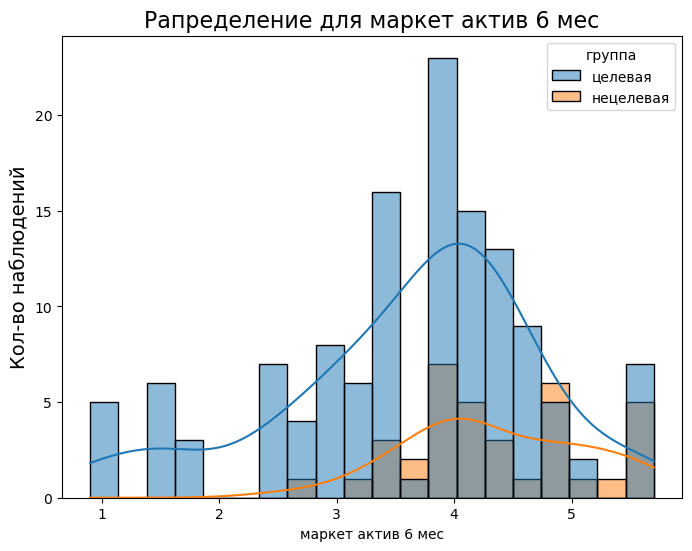

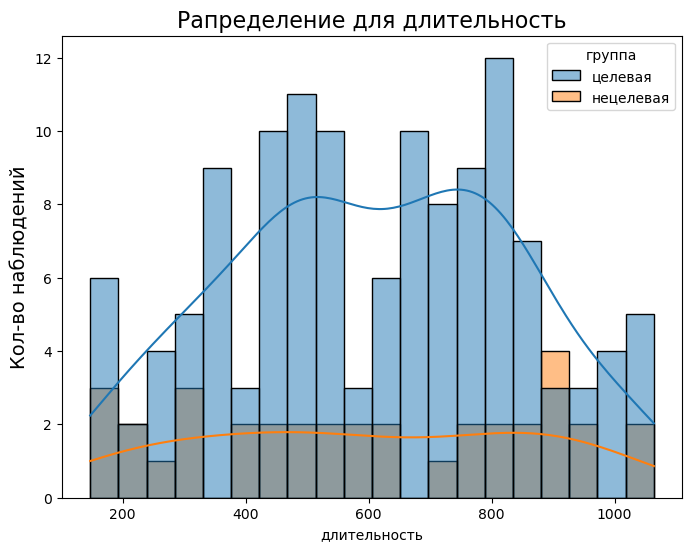

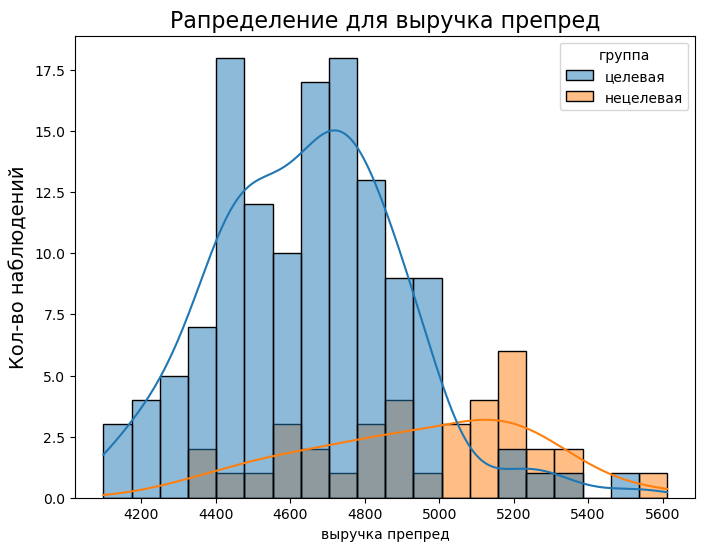

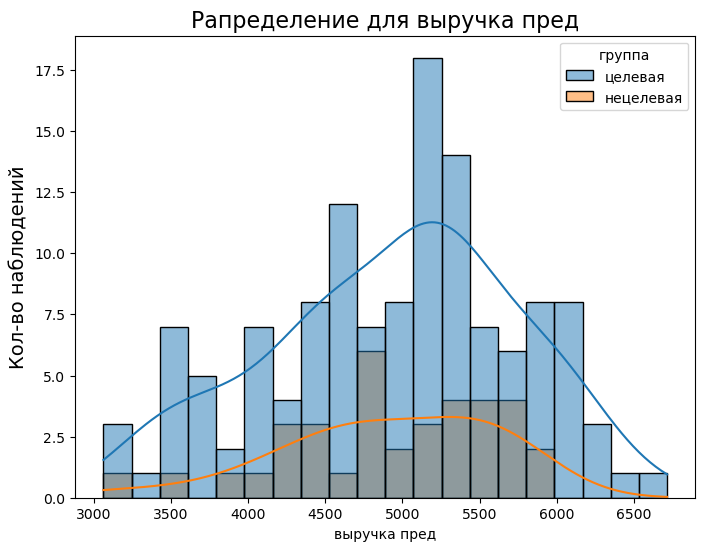

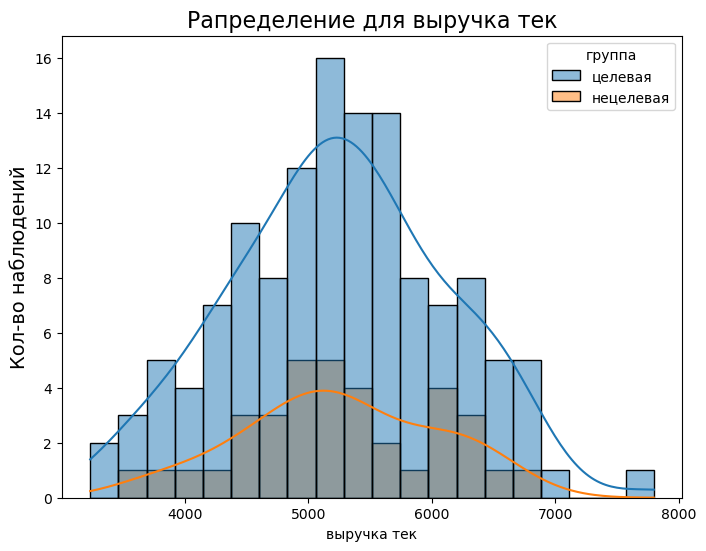

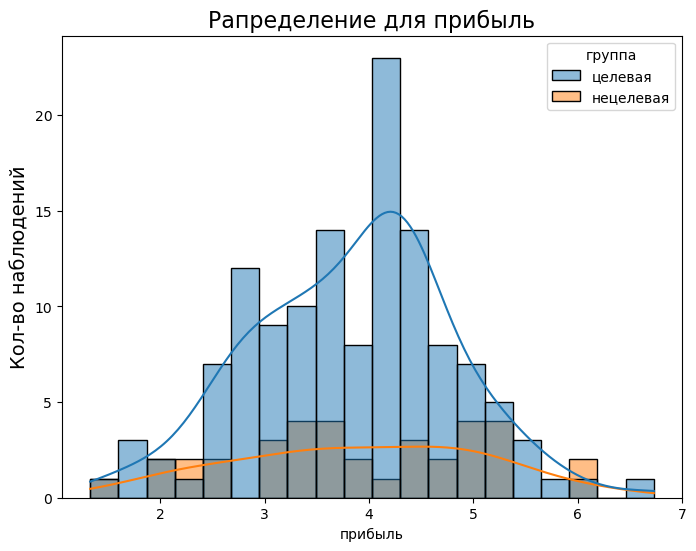

In [77]:
for i in ['маркет актив 6 мес', 'длительность', 'выручка препред', 'выручка пред', 'выручка тек', 'прибыль']:
    plot_hist(qq, i, 'группа')

## Итоговый вывод<a id="20"></a>

В данной работе была поставлена задача разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность. Для этого был проведен полный цикл работы: от обработки данных до выводов на основе построенной модели машинного обучения.

**Были загружены:**

1. Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.;

3. Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом;

3. Таблица с данными о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю;

5. Таблица с данными о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

**Была проведена предобработка данных:**

1. Названия столбцов приведены к нижнему регистру с пробелами
2. Тип данных датасета money для колонки "прибыль" должна исправлена на float
3. Были проверены пропуски и явлые дубликаты
4. Была проведена обработка **неявных дубликатов**:

market_customer_df:

* тип сервиса -'стандартт' и 'стандарт'
* популярная категория: 'аксесуары' (орфографическая ошибка)
* Некоторые столбцы имеют большие буквы

market_money_df:

* 'препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц' - подчеркаивания вместо пробелов

market_time_df:

* 'предыдцщий_месяц' (орфографическая ошибка)
* 'текущий_месяц' 'предыдцщий_месяц' - подчеркаивания вместо пробелов

**Был проведен исследовательский анализ данных:**

По результатам анализа распределения количественных признаков сделаны выводы:

* Некоторые показатели в данных выглядят близко к нормальному закону или совсем его напоминают. Примером служат переменные ошибка сервиса, страниц за визит и среднее число просмотров категорий за визит.

* Группировка по доле акционных покупок. Всех покупателей разбили на две категории по тому, какова была их средняя месячная доля покупок по акции за последние полгода:

* Низкая активность по акциям: доля акционных покупок ≤ 0,5.
* Высокая активность по акциям: доля акционных покупок ≥ 0,8.
* Распределение «длительности». Параметр длительность (количество дней от регистрации клиента до текущей даты) почти равномерно распределён, однако на гистограмме всё же заметен отчётливый пик.

Анализ значений внутри признаков показал:
* Ряд показателей в наших данных демонстрирует распределение, близкое к нормальному — к таким относятся, например, значения `ошибка_сервиса`, `страниц_за_визит` и среднее число просмотров категорий за визит.
* По доле акционных покупок покупателей за последние шесть месяцев выделены две группы: с среднемесячным показателем до 0,5 и с показателем свыше 0,8.
* Параметр `длительность` (число дней с момента регистрации на сайте) практически равномерно распределён, однако на гистограмме отчётливо виден один выраженный пик.
* При построении боксплота для столбца `маркет_актив_6_мес` обнаружено 36 выбросов за границами усов, но они сконцентрированы в четырёх повторяющихся значениях, поэтому были сохранены в наборе данных.
* В выборке заметен дисбаланс классов, что потребует особого внимания при построении и настройке моделей.
* Среди клиентов с пониженной активностью основное снижение приходится на число просмотренных страниц и категорий. При этом среди «падающих» пользователей выше доля любителей акционных предложений, что может указывать на их склонность к сокращению покупок. Высокое количество неоплаченных товаров также может служить сигналом об усталости или потере интереса к покупкам.
* Клиенты, чья активность снизилась, стали просматривать меньше страниц за визит и реже переходить в разные категории товара – другими словами, они значительно сократили изучение сайта.
* При этом в группе с пониженной активностью оказалась непропорционально большая доля покупателей, активно пользующихся акциями, что может свидетельствовать о том, что любители скидок более склонны к спаду в своих покупательских привычках.
* Кроме того, среди «ухудшивших» свою активность пользователей чаще встречаются высокие значения признака `неоплаченные_продукты_штук_квартал`, что, по-видимому, тоже указывает на снижение их вовлечённости в покупки.

**Затем данные были объединены и проведен корреляционный анализ на основе нового получившегося датасета:**
1. Попарные корреляции между независимыми фичами не превышают |0.7|, поэтому серьёзного мультиколлинеарного эффекта нет.
2. Максимальное значение ≈ 0.36 наблюдается между «минут тек» и «минут пред», что далеко ниже критических порогов.
3. Единственная очень сильная связь (≈ 0.88) — между «выручка пред» и «выручка тек», но это не показатель коллинеарности входных переменных, а закономерность прогноз
4. Не буду покамест ничего удалятьях.

**Пайплайн:**

1) Для оценки качества модели была использована метрика качества ROC-AUC для оценка модели вне зависимости от порогов классификации, а еще она устойчива к дизбалансу классов.
2) В пайплайне были добавлены сегменты для преобразования численных, порядковых и категориальных данных.
3) В пайплайне были добавлены четыре модели машинного обучения: DecisionTreeClassifier, LogisticRegression, KNeighborsClassifier, SVC
4) На кросс-валидации было получено значение метрики ROC-AUC approx. 0.9, что является отличным результатом
5) На тестовой выборке было получено значение ROC-AUC 0.91

**Был проведен анализ важности признаков:**
1. Самое влиятельное – вовлечённость пользователя: количество просмотренных страниц за визит и время, проведённое на сайте. Чем больше этих показателей, тем выше вероятность целевого действия.
2. Среднее число просмотров разных категорий за визит тоже положительно коррелирует с конверсией: пользователи, активно изучающие ассортимент, чаще совершают целевое действие.
3. Обратная связь с «брошенными» товарами важна: если за квартал накопилось много неоплаченных позиций, то шансы на покупку снижаются.
4. Акции работают не так эффективно: частые «акционные» покупки дают небольшой отрицательный вклад в конверсию, вероятно, эти клиенты больше ждут скидок и реже покупают по обычным ценам.
5. История выручки по предыдущим периодам умеренно влияет – более высокие продажи в прошлом слегка повышают вероятность покупки сегодня.
6. Технические нюансы (флаг ошибки сервиса, длительность сессии) и категориальные маркеры (тип сервиса, популярность конкретных товарных категорий) имеют малозначимый эффект и практически не меняют прогноз модели.

**Сегментация покупателей:**

Проверялась теория о том, что любители акционных покупок склонны снижать свою покупательскую активность и выяснили, что пользователи, которые собираются снизить свою активность обычно довольно экономны и выбирают тип сервиса "стандарт". Они также следят за скидками и акциями и в подовляющем случае подписаны на рассылку. Судя по всему это женщины и семьи с детьми. Возможно, стоит их приманивать скидками на категории товаров для женщин и детей.

## Рекомендации бизнесу <a id = "21"></a>

Учитывая сделанные выводы, можно говорить, что для сокращения оттока покупателей, нужно целиться в аудиторию тех, кто хочет максимально сэконоить и выгодно приобрести некоторые категории товаров. В таком случае я могу предполоить несколько потенциально успешных вариантов для магазина:

1) Провести распродажу товаров для детей
2) Ввести накопительные скидки на товары для дома, для детей и косметику по клубной карте магазина
3) Запустить рассылку с уникальными промокодами на покупку. Найти оптимальное соотношение исклчительно рекламных рассылок и рекламных рассылок с промокодами
4) Делать крупные закупки в преддверии знаковых для детей дат: 1 сентября, конец июня и т.п... Закупать парты, рюкзаки, канцелярию перед началом учебного года, коляски перед теплым сезоном и т.д...
5) Устроить беспроигрышную лотерею в магазине при покупке определенных товаров. Встроить в сайт скидки на таймере, колеса фортуны и подарки за покупку
6) Ввести реферальную систему, чтобы желающие прекратить взаимодействие с магазином получили повод сделать несколько новых покупок и распространить о магазине информацию по сарафанному радио

Правильное сочитание мер по воздействию на береждивых покупателей с детьми поможет магазину "В один клик" поправить свое положение